# Final Project

## Data Overview

Data Description : <br>
This dataset provides a synthetically generated, comprehensive record of coffee shop transactions spanning July 2023 to June 2025. It is specifically designed to simulate the crucial period following the launch of a new customer membership program and mobile application, offering a unique lens into the evolving dynamics of customer engagement and purchasing behavior.

**Dataset Description:**

The training dataset contains `2240 samples`. Contains `28 features` and `1 target boolean` variable `"Response"` :

**menu_items dataset**

- `item_id` - Item's id
- `item_name` - Item's Name
- `category` - Item's category
- `price` - Item Price
- `is_seasonal` - Item's seasonal Description (False and True)
- `available_from` - Item's Available from
- `available_to` - Item's Available to

**payment_methods dataset**

- `method_id` - Payment Methode's id
- `method_name` - Payment method name
- `category` - Payment Categoty

**stores dataset**

- `store_id` - Store's ID
- `store_name` - Store's Name
- `street` - Store's Streer Address
- `postal_code` - Store's Postal Code
- `city` - Store's City Address
- `state` - Store's state Address
- `latitude` - Store's Latitude Address
- `longitude` - Store's Longitude Address

**transaction_items_yearmonth dataset**

- `transaction_id` - Transaction's ID
- `item_id` - Item's id
- `quantity` - Transaction Quantity
- `unit_price` - Item Price
- `subtotal` - unit_price * quantity
- `created_at` - Date & time created

**transaction_yearmonth dataset**

- `transaction_id` - Transaction's ID
- `store_id` - Store's ID
- `payment_method_id` - Payment methos ID
- `voucher_id`- Voucher's ID
- `user_id` - User ID
- `original_amount` - amount without discount
- `discount_applied` - discount applied
- `Final_amount` - Final Price after discount applied
- `created_at` - transaction Date and Time

**user_yearmonth dataset**

- `user_id` - User ID
- `gender` - User gender
- `birthdate` - User Birthdate
- `registered_at`- User Registered date 

**Cost and Revenue**

- `voucher_id` - Voucher's ID
- `Voucher_code` - Voucher's Code
- `discount_type` - Voucher Discount Type
- `discount_value` - Discount Value
- `valid_from` - Vouchers Start Date
- `valid_to` - Vouchers End Date


## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import math
from scipy.stats import skew
from scipy.stats import kurtosis

### Data Understanding

#### Read Dataset

Before Going on with the code some of csv files need to place into 3 different files : <br>
1. transaction_items
2. transactions
3. users

you can download data from this site : <br>
https://www.kaggle.com/datasets/geraldooizx/g-coffee-shop-transaction-202307-to-202506

In [ ]:
# Path to all your CSV files
files_transaction_items = glob.glob("***/transaction_items/*.csv")
files_transactions = glob.glob("***/transactions/*.csv")
files_users = glob.glob("***/users/*.csv")

# Read and combine
df_transaction_items = pd.concat((pd.read_csv(f) for f in files_transaction_items), ignore_index=True)
df_transaction = pd.concat((pd.read_csv(f) for f in files_transactions), ignore_index=True)
df_users = pd.concat((pd.read_csv(f) for f in files_users), ignore_index=True)
df_menu_items = pd.read_csv('menu_items.csv')
df_payment_methods = pd.read_csv('payment_methods.csv')
df_store = pd.read_csv('stores.csv')
df_voucher = pd.read_csv('vouchers.csv')

This final project focuses on Customer Segmentation using RFM Analysis.
The dataset that includes the Customer ID is the “transaction_yearmonth” dataset, and it can be combined with other datasets if deeper analysis is required.

#### Basic Dataset Information

In [3]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14623691 entries, 0 to 14623690
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transaction_id     object 
 1   store_id           int64  
 2   payment_method_id  int64  
 3   voucher_id         float64
 4   user_id            float64
 5   original_amount    float64
 6   discount_applied   float64
 7   final_amount       float64
 8   created_at         object 
dtypes: float64(5), int64(2), object(2)
memory usage: 1004.1+ MB


In [4]:
# Check Missing Value
df_transaction.isna().sum()

transaction_id              0
store_id                    0
payment_method_id           0
voucher_id           14006140
user_id               7310827
original_amount             0
discount_applied            0
final_amount                0
created_at                  0
dtype: int64

In [5]:
# Check Duplicate
df_transaction.duplicated().sum()

np.int64(0)

In [6]:
print('Missing values status:', df_transaction.isnull().values.any())
nvc = pd.DataFrame(df_transaction.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_transaction.shape[0])*100
nvc["Data Type"] = [df_transaction[col].dtype for col in df_transaction.columns]
nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)
nvc.style.background_gradient(cmap='Blues')

Missing values status: True


,Total Null Values,Percentage,Data Type
voucher_id,14006140,95.777051,object
user_id,7310827,49.993035,float64
transaction_id,0,0.000000,object
store_id,0,0.000000,int64
payment_method_id,0,0.000000,int64
original_amount,0,0.000000,float64
final_amount,0,0.000000,float64
discount_applied,0,0.000000,float64
created_at,0,0.000000,float64


<Figure size 1000x600 with 0 Axes>

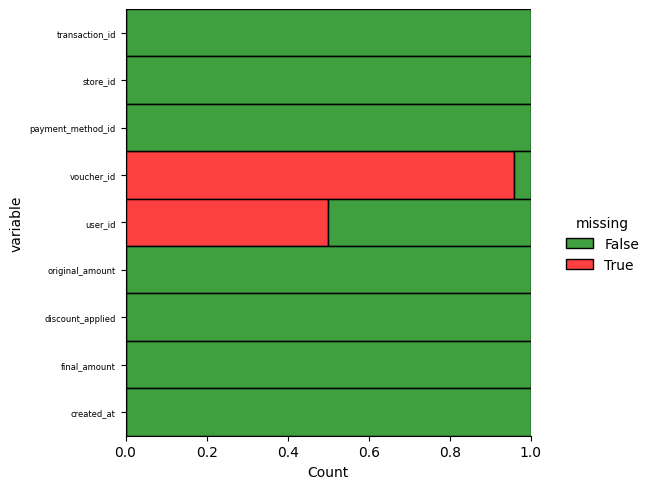

In [7]:
plt.figure(figsize=(10,6))

dms = sns.displot(
    data=df_transaction.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette = ["green","red"]
)

dms.set_yticklabels(size = 6)

**Observations:**

- Dataset memiliki `9 columns` dan `14623691 rows` data
- Terdapat 3 jenis tipe data yaitu : `int64, object, float64`
- Kolom `Voucher_id` memiliki 617551 nilai non-null, dan `14006140 nilai null / missing values`
- Kolom `user_id` memiliki 7312864 nilai non-null, dan `7310827 nilai null / missing values`


**Hal yang harus dilakukan saat Data Pre-Processing adalah:**

- Karena analisis yang dilakukan adalah Customer Segmentation maka data yang tidak memiliki user_id akan dilakukan Drop Row. jika tidak akan berpengaruh kepada nilai recency dan frequency pada saat penentuan RFM.
- untuk voucher_id, karena voucher bukan merupakan informasi dasar yang harus dimiliki dan menjadi salah satu faktor yang bisa dianalisis maka yang tidak memiliki voucher ID akan dianggap tidak mendapatkan voucher atau nilai 0.

#### Division by Type of Data 

In [8]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14623691 entries, 0 to 14623690
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transaction_id     object 
 1   store_id           int64  
 2   payment_method_id  int64  
 3   voucher_id         float64
 4   user_id            float64
 5   original_amount    float64
 6   discount_applied   float64
 7   final_amount       float64
 8   created_at         object 
dtypes: float64(5), int64(2), object(2)
memory usage: 1004.1+ MB


**List of Column Types:**

- **Date**

    `created_at`

- **Categorical** (5 Columns) : 

    `transaction_id`, `store_id`, `payment_method_id`, 
    `voucher_id`, `user_id` - Nominal

- **Continuous** (3 Columns):

    `original_amount, discount_applied	final_amount`

 ##### Change Type of data

In [9]:
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])
df_transaction

,transaction_id,store_id,payment_method_id,voucher_id,user_id,original_amount,discount_applied,final_amount,created_at
0,2ae6d188-76c2-4095-b861-ab97d3cd9312,4,5,NaN,NaN,38.0,0.0,38.0,2023-07-01 07:00:00
1,7d0a474d-62f4-442a-96b6-a5df2bda8832,7,1,NaN,NaN,33.0,0.0,33.0,2023-07-01 07:00:02
2,85f86fef-fddb-4eef-9dc3-1444553e6108,1,5,NaN,NaN,27.0,0.0,27.0,2023-07-01 07:00:04
3,4c41d179-f809-4d5a-a5d7-acb25ae1fe98,5,2,NaN,NaN,45.5,0.0,45.5,2023-07-01 07:00:21
4,51e44c8e-4812-4a15-a9f9-9a46b62424d6,8,5,NaN,NaN,27.0,0.0,27.0,2023-07-01 07:00:33
...,...,...,...,...,...,...,...,...,...
14623686,ac96bb0f-fd77-494e-8752-0eeb914bc5f6,1,2,NaN,1710441.0,69.0,0.0,69.0,2025-06-01 14:18:43
14623687,4f4f8a0d-93dd-4374-99c9-0bc7f1221076,8,1,NaN,97151.0,14.0,0.0,14.0,2025-06-01 14:18:44
14623688,69b46738-f158-409b-be08-5d5cd91b0ce3,3,4,NaN,215599.0,27.0,0.0,27.0,2025-06-01 14:18:45
14623689,29dcf7e6-6b53-4823-a7e5-30da9199c537,8,1,NaN,1398327.0,17.0,0.0,17.0,2025-06-01 14:18:46


##### Drop row on NAN User ID 

In [10]:
df_transaction = df_transaction.dropna(subset=['user_id'])

##### Manipulate NaN Voucher_id with 0

In [11]:
df_transaction['voucher_id'] = df_transaction['voucher_id'].fillna(0)

C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\894170443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transaction['voucher_id'] = df_transaction['voucher_id'].fillna(0)


##### Change the categorical data into categorical type

In [12]:
cat_col = ['transaction_id','store_id', 'payment_method_id','voucher_id','user_id']
df_transaction[cat_col] = df_transaction[cat_col].astype('category') 

C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\2249009977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transaction[cat_col] = df_transaction[cat_col].astype('category')


#### Statistical Summary

In [13]:
df_transaction.describe()

,original_amount,discount_applied,final_amount,created_at
count,7.312864e+06,7.312864e+06,7.312864e+06,7312864
mean,3.324393e+01,1.441881e-01,3.309975e+01,2024-12-13 13:58:45.826885120
min,6.000000e+00,0.000000e+00,1.000000e+00,2023-07-01 08:13:07
25%,1.900000e+01,0.000000e+00,1.900000e+01,2024-09-14 11:28:53.500000
50%,3.100000e+01,0.000000e+00,3.100000e+01,2024-12-26 15:33:03.500000
75%,4.550000e+01,0.000000e+00,4.500000e+01,2025-03-30 13:39:39.500000
max,9.000000e+01,4.500000e+01,9.000000e+01,2025-06-30 19:59:39
std,1.705474e+01,1.108885e+00,1.702784e+01,NaN


**Observations and Preprocessing Suggestions:**

- **Moderately Positively Skewed (Sedikit skew ke kanan) pada kolom :**

    `original_amount, final_amount`
    
    Jika dilihat pada data ini nilai `mean dan median` yang memiliki jarak yang tidak lumayan jauh, namun kemungkinan memiliki distribusi yang `skewed` ke kanan, maka perlu di visualisasi lebih lanjut
    
- **discount_applied**

    Dapat diketahui bahwa hampir 90% dari data tidak mendapatkan voucher sehingga Q1 median dan Q3 bernilai 0.

In [14]:
df_transaction[cat_col].describe().transpose()

,count,unique,top,freq
transaction_id,7312864,7312864,ffffe58d-024c-413c-972b-3edaa53deb06,1
store_id,7312864,10,4,733068
payment_method_id,7312864,5,4,1463091
voucher_id,7312864.0,17.0,0.0,7046220.0
user_id,7312864.0,2196257.0,5.0,40.0


**Observations :**

- `transaction_id` : dapat diketahui bahwa transaction ID tidak ada yang duplicate dengan masing - masing jumlah frekuensi unik adalah 1
- `store_id` : Terdapat jumlah toko ada 10 dengan transaction terbanyak ada di toko 4(733068)
- `payment_method_id` : Terdapat jumlah payment methode ada 5 dengan transaction terbanyak ada di method 4(1463091)
- `voucher_id` : Terdapat jumlah jenis voucher ada 5 dengan voucher terbanyak ada di voucher 0 (tidak dapat voucher) sebanyak (1463091)
- `user_id` : terdapat customer sebanyak 2196257 yang terdaftar dan akan dilakukan analisis Customer Segmentation

Dan Jika dilihat dari jumlah count masing-masing category sama yang mengindikasikan tidak terdapat duplicate atau missing value

## Exploratory Data Analysis (EDA)

### Uni-Variate Analysis

#### Individual Boxplot and Violinplot

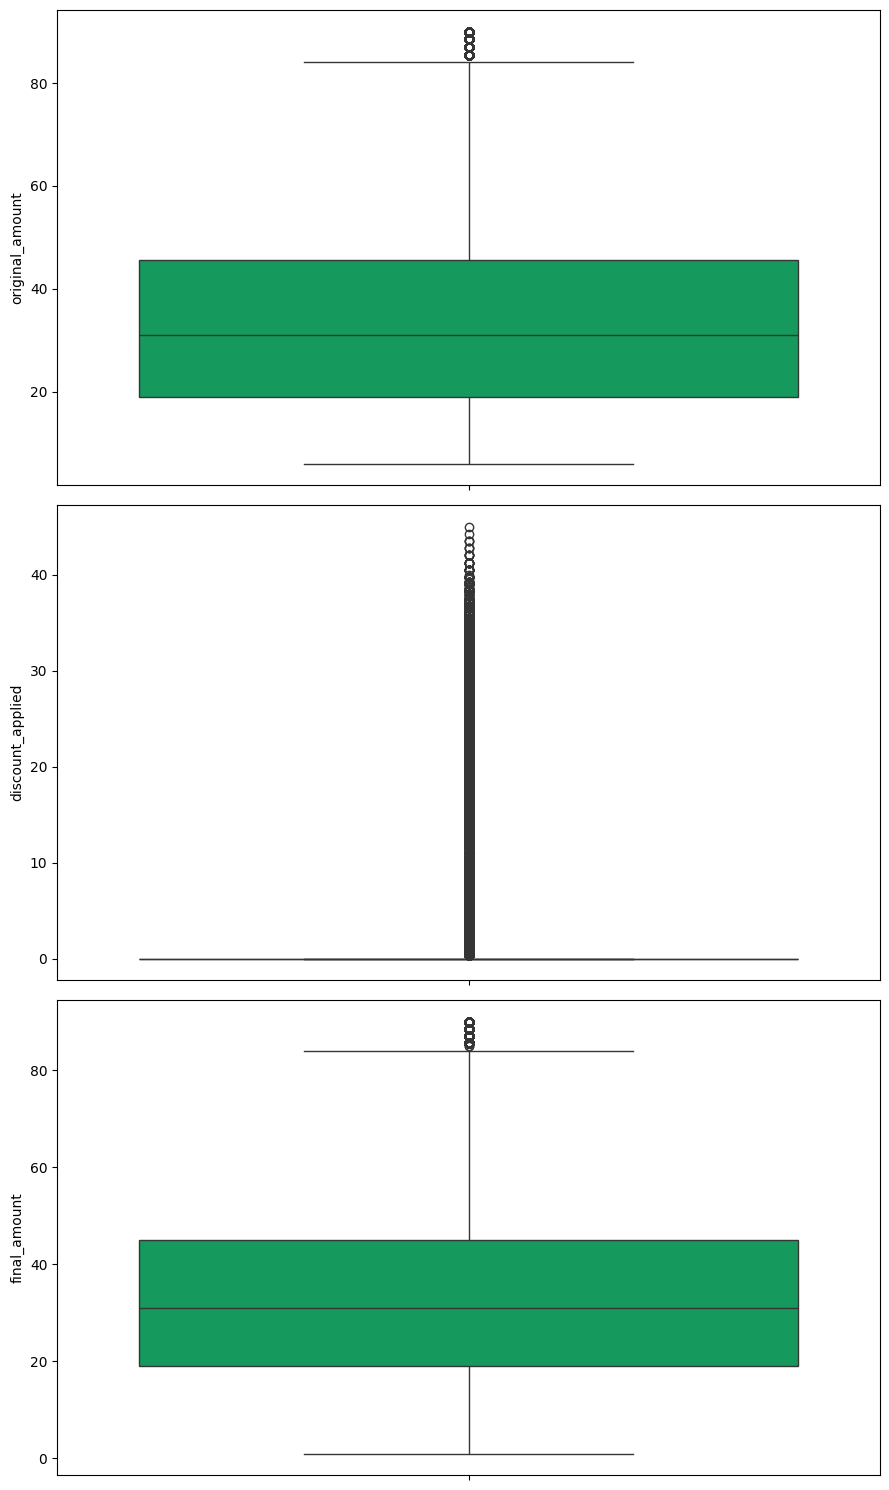

In [15]:
con_cols = ['original_amount', 'discount_applied',	'final_amount']
plt.figure(figsize=(9, 15))
n = 3
for i in range(0, len(con_cols)):
    plt.subplot(n, math.ceil(len(con_cols)/n), i+1)
    sns.boxplot(y=df_transaction[con_cols[i]], color='#00af5f', orient='v')
    plt.tight_layout()

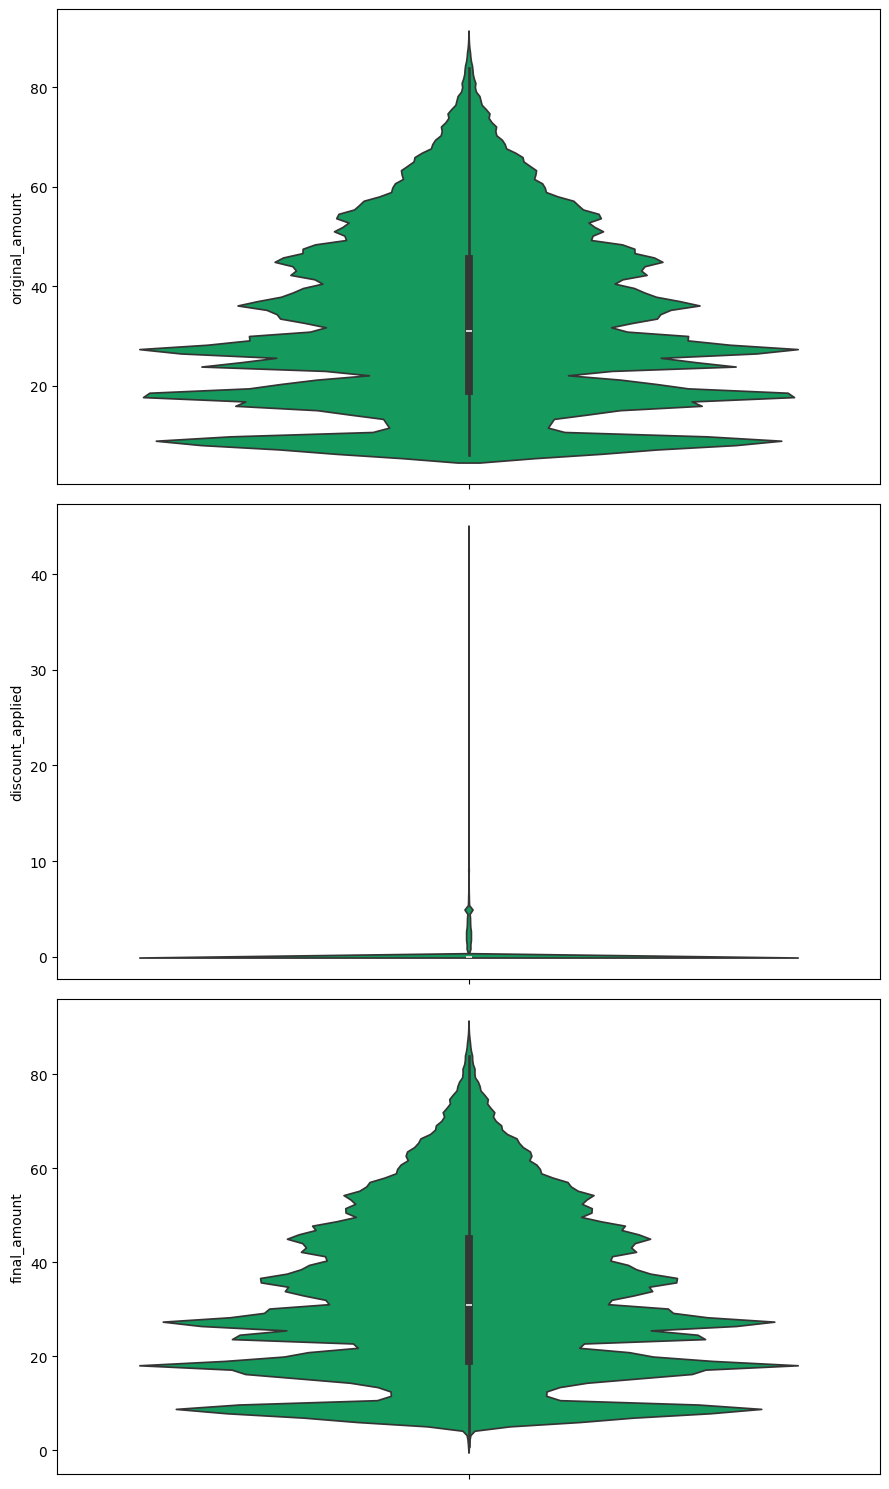

In [16]:
plt.figure(figsize=(9, 15))
n = 3
for i in range(0, len(con_cols)):
    plt.subplot(n, math.ceil(len(con_cols)/n), i+1)
    sns.violinplot(y=df_transaction[con_cols[i]], color='#00af5f',orient='v')
    plt.tight_layout()

#### Outlier Check

In [17]:
print(f'Jumlah baris: {len(df_transaction)}')

outlier = []
no_outlier = []
is_outlier = []
low_lim = []
high_lim = []

filtered_entries = np.array([True] * len(df_transaction))
for col in con_cols:
    Q1 = df_transaction[col].quantile(0.25)
    Q3 = df_transaction[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filter_outlier = ((df_transaction[col] >= low_limit) & (df_transaction[col] <= high_limit))
    outlier.append(len(df_transaction[~filter_outlier]))
    no_outlier.append(len(df_transaction[filter_outlier]))
    is_outlier.append(df_transaction[col][~filter_outlier].any())
    low_lim.append(low_limit)
    high_lim.append(high_limit)

    filtered_entries = ((df_transaction[col] >= low_limit) & (df_transaction[col] <= high_limit)) & filtered_entries

print("Outlier All Data :", len(df_transaction[~filtered_entries]))
print("Not Outlier All Data :", len(df_transaction[filtered_entries]))
print()

pd.DataFrame({
    "Column Name":con_cols,
    "is Outlier": is_outlier,
    "Lower Limit": low_lim,
    "Upper Limit": high_lim,
    "Outlier":outlier,
    "No Outlier":no_outlier
})

Jumlah baris: 7312864
Outlier All Data : 270942
Not Outlier All Data : 7041922



,Column Name,is Outlier,Lower Limit,Upper Limit,Outlier,No Outlier
0,original_amount,True,-20.75,85.25,4474,7308390
1,discount_applied,True,0.00,0.00,266644,7046220
2,final_amount,True,-20.00,84.00,4300,7308564


**Observations and Suggestion**

Terdapat outlier pada kolom `original_amount, discount_applied, final_amount`

- Pada kolom `original_amount` dan `final_amount`, outlier berada di range normal melihat dari persebaran data sebelumnya dan outlier ini masih batas wajar karena melihat dari boxplot dan violin plot bahwa data outlier berada diatas Upper Limit sehingga tidak dilakukan pembersihan outlier
- Pada kolom `dicount_applied`, hampir semua data berada pada outlier karena tidak semua customer mendapatkan discount sehingga tidak dilakukan pembersihan

#### Individual Histogram

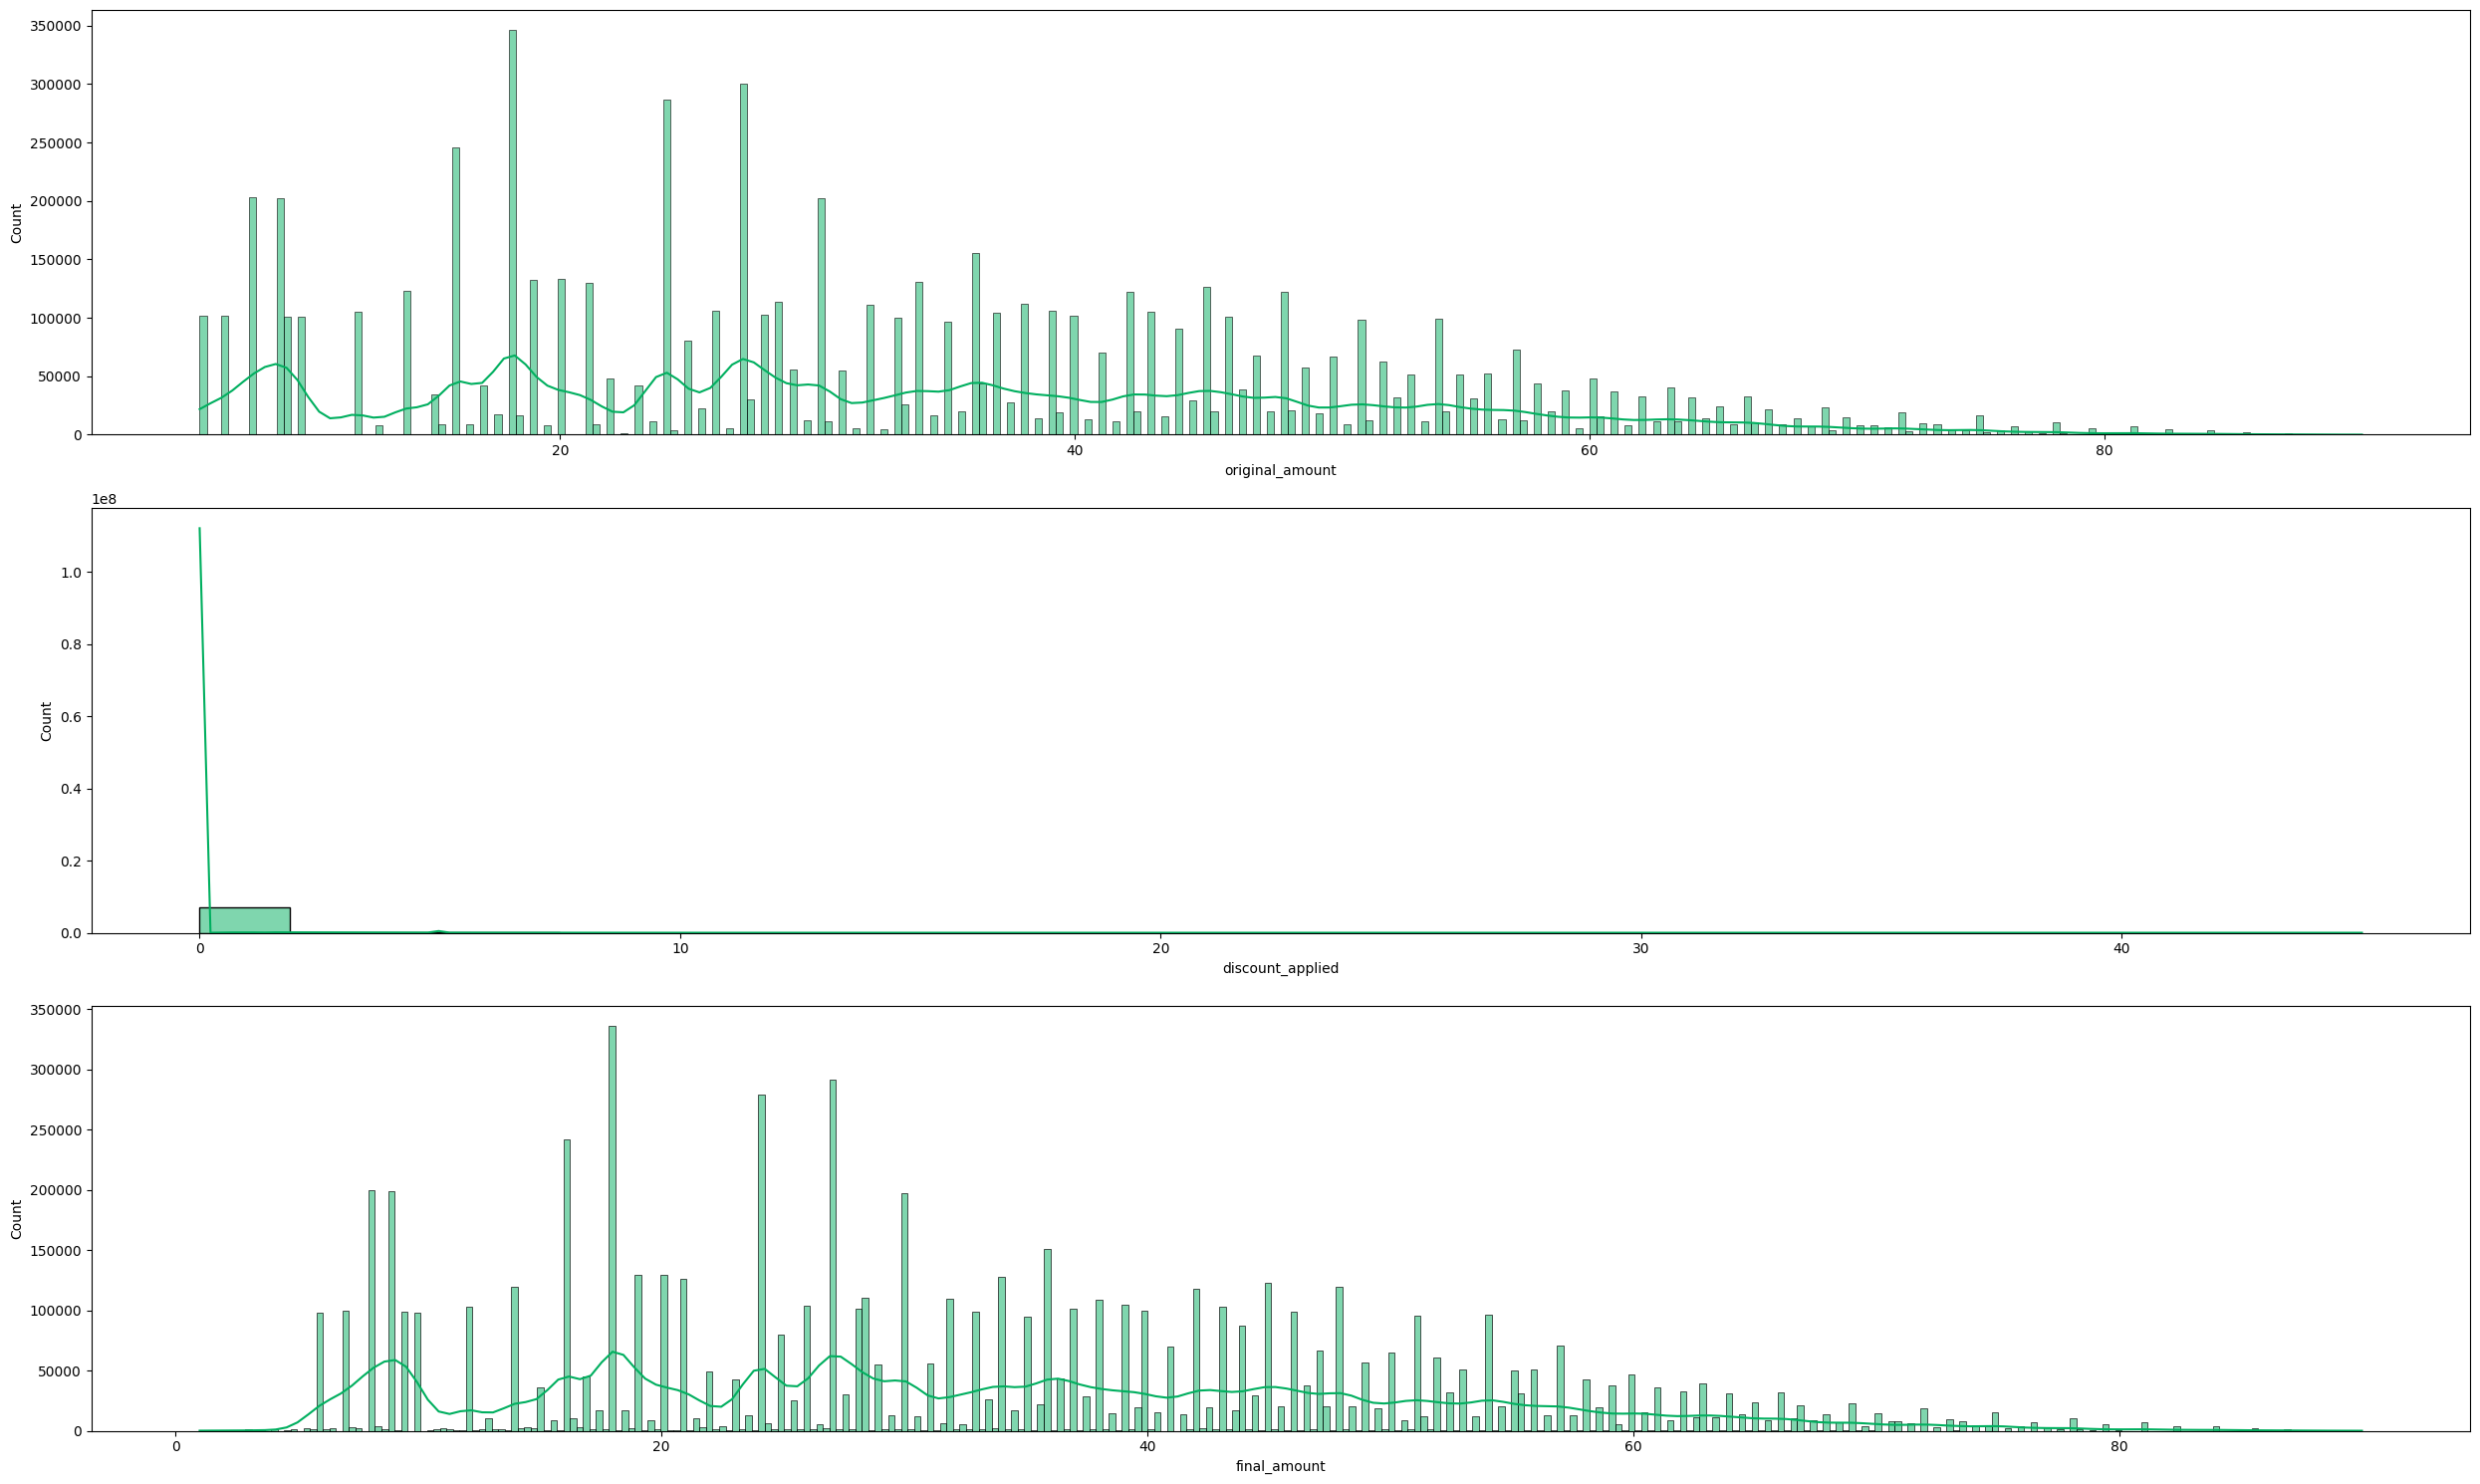

In [18]:
plt.figure(figsize=(25, 15))
n = 3
for i in range(0, len(con_cols)):
    plt.subplot(n, math.ceil(len(con_cols)/n), i+1) 
    sns.histplot(df_transaction[con_cols[i]], color='#00af5f', kde=True)
    plt.tight_layout()

In [19]:
skew_type_list = []
skew_val_list = []
kurtosis_val_list = []

for column in con_cols:
    data = df_transaction[column].dropna(axis=0) 
    q1 = data.quantile(q=0.25)
    mean = round(data.mean(), 3)
    median = data.median()
    mode = data.mode()[0]
    q3 = data.quantile(q=0.75)
    # skew_val = round(data.skew(),3)
    skew_val = round(skew(data, nan_policy="omit"),3)
    kurtosis_val = round(kurtosis(data, nan_policy="omit"),3)

    if (mean == median == mode) or (-0.2 < skew_val < 0.2):
        skew_type = "Normal Distribution (Symmetric)"
    elif mean < median < mode:
        skew_type = "Negatively Skewed"
        if skew_val <= -1:
            skew_type = "Highly Negatively Skewed"
        elif -0.5 >= skew_val > -1:
            skew_type = "Moderately Negatively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    else:
        skew_type = "Positively Skewed"
        if skew_val >= 1:
            skew_type = "Highly Positively Skewed"
        elif 0.5 <= skew_val < 1:
            skew_type = "Moderately Positively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    skew_type_list.append(skew_type)
    skew_val_list.append(skew_val)
    kurtosis_val_list.append(kurtosis_val)
            
dist = pd.DataFrame({
    "Column Name":con_cols,
    "Skewness": skew_val_list,
    "Kurtosis": kurtosis_val_list,
    "Type of Distribution": skew_type_list
})

dist

,Column Name,Skewness,Kurtosis,Type of Distribution
0,original_amount,0.395,-0.563,Moderately Normal Distribution (Symmetric)
1,discount_applied,15.869,352.211,Highly Positively Skewed
2,final_amount,0.399,-0.557,Moderately Normal Distribution (Symmetric)


Berdasarkan chart **Boxplot, Distribusi, dan Violin** diatas, dapat diketahui bahwa `original_amount` dan `final_amount` terdistribusi dengan normal dan `discount_applied` terdistribusi secara positif karena memang banyak customer yang tidak mendapatkan discount atau terpusat pada angka 0

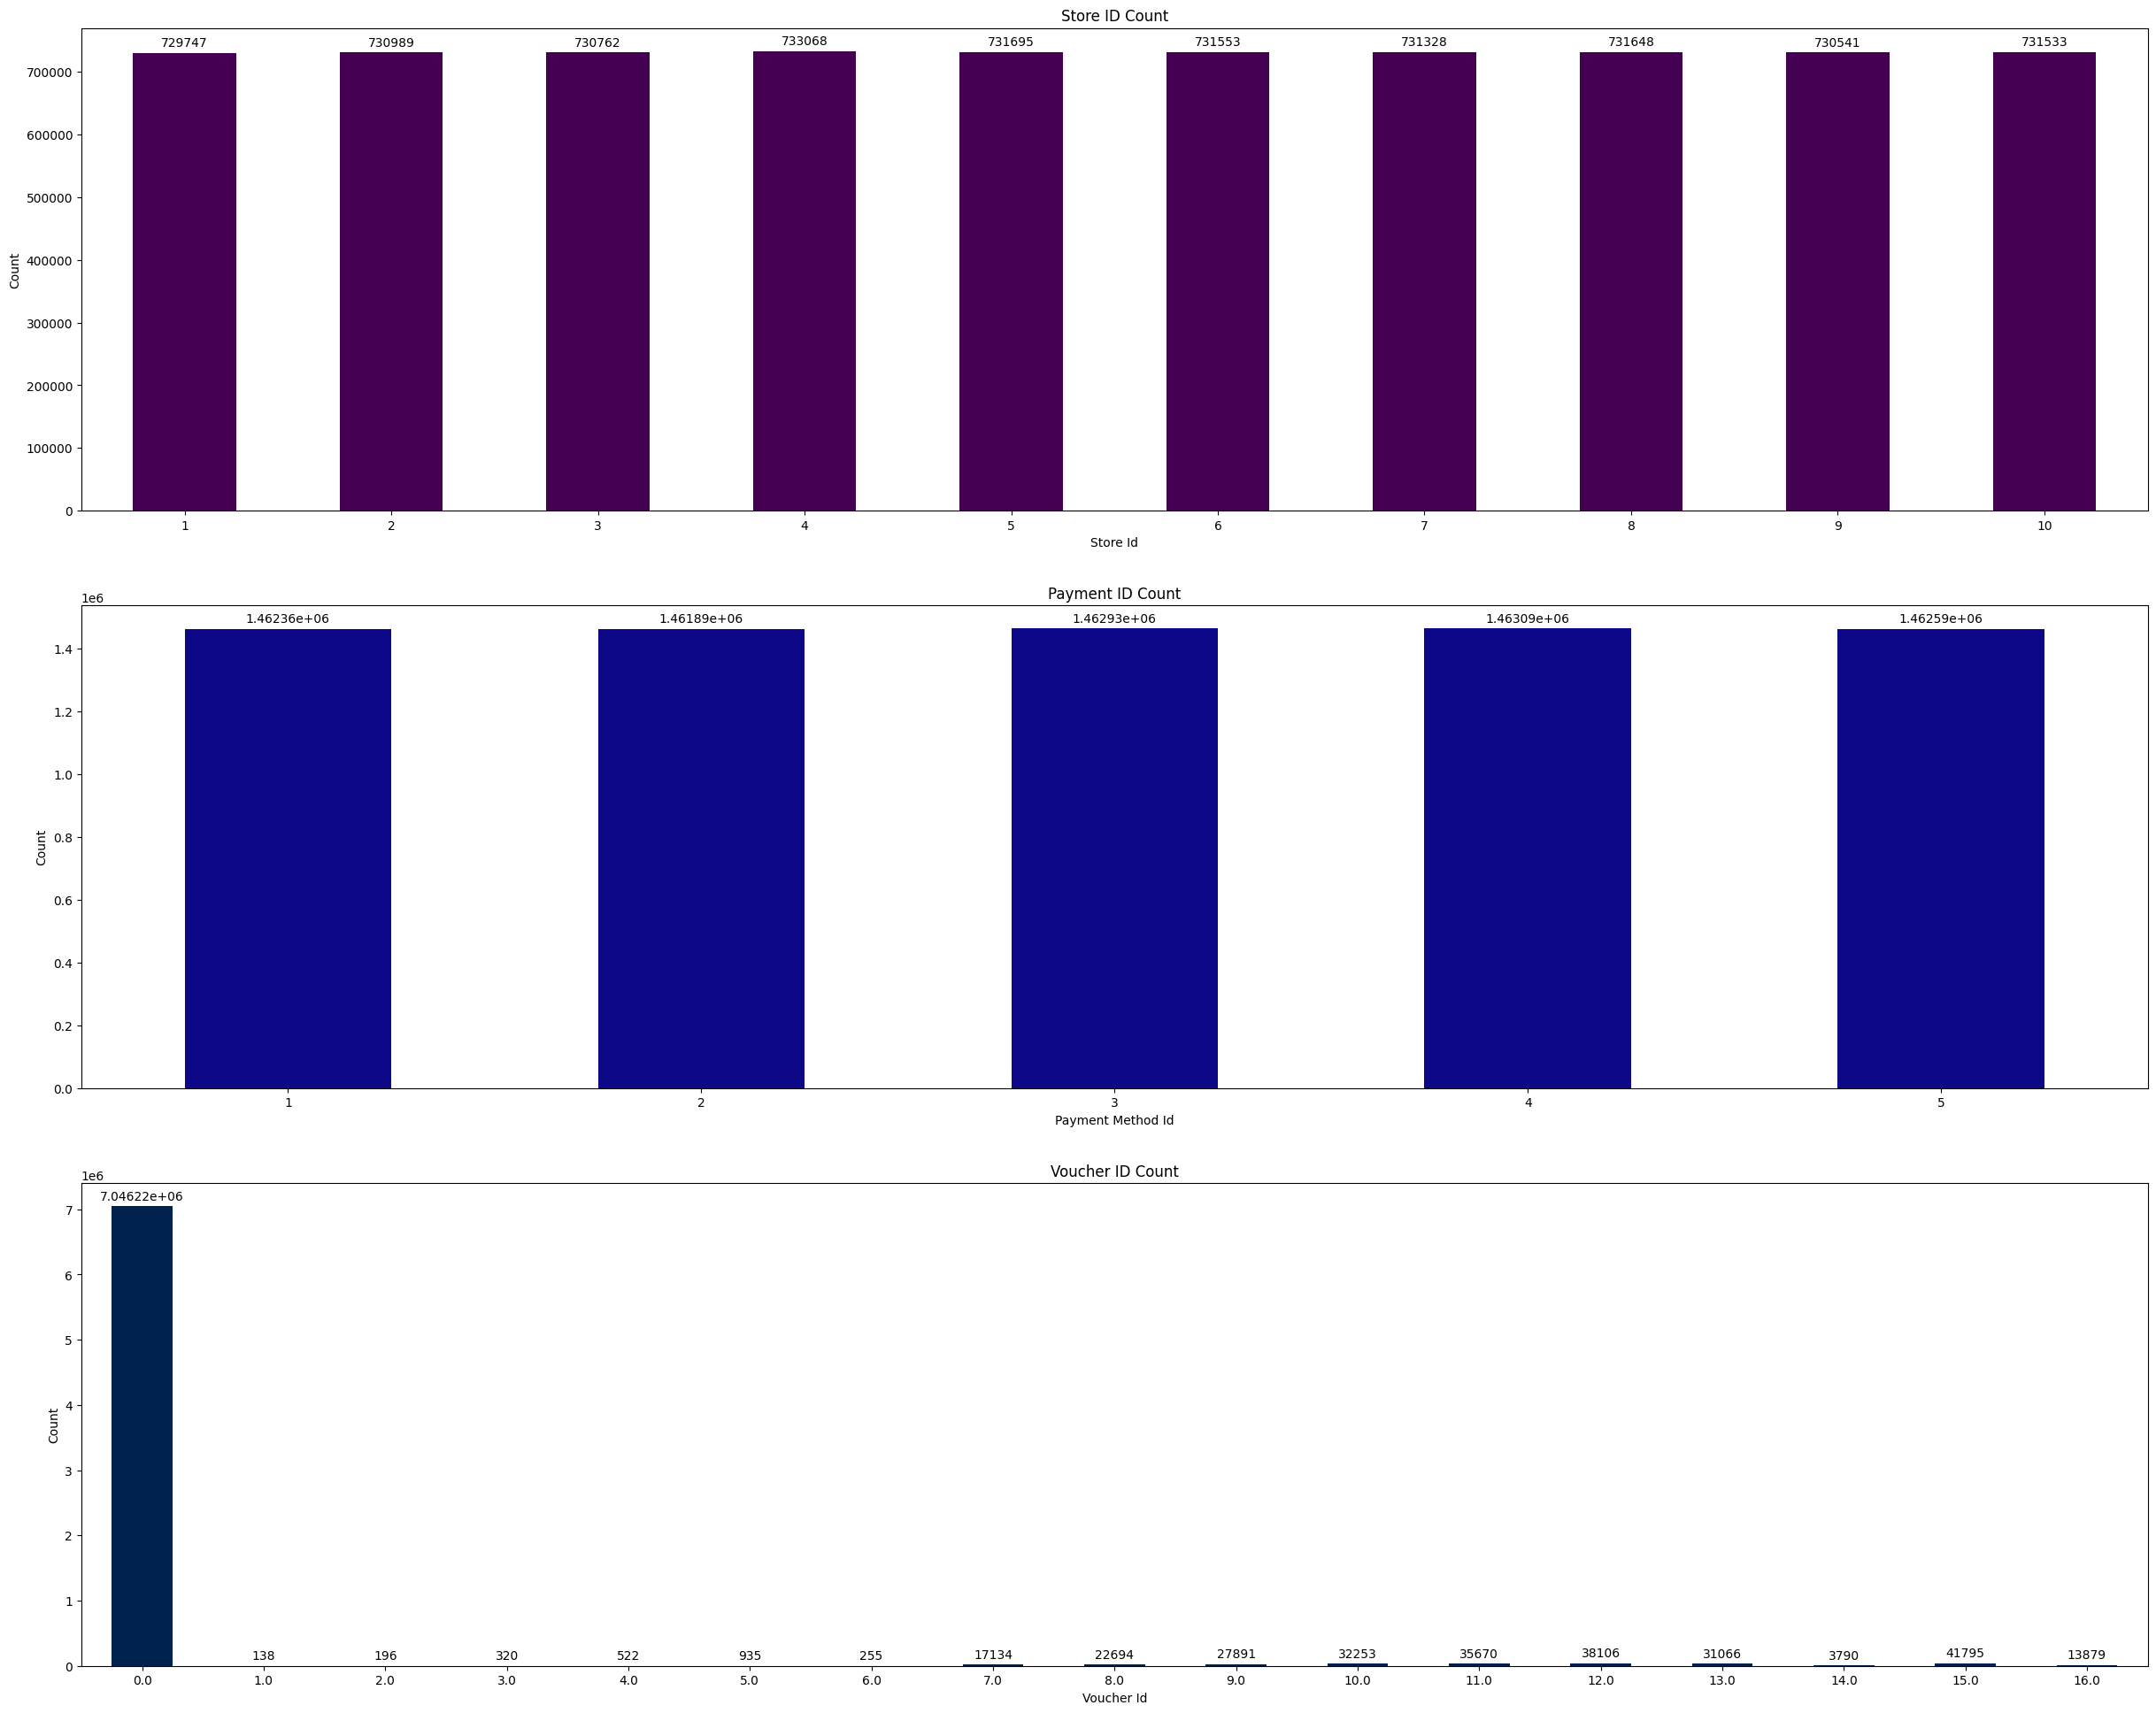

In [20]:
plot_data = {
    'store_id': df_transaction['store_id'].value_counts().sort_index(),
    'payment_method_id': df_transaction['payment_method_id'].value_counts().sort_index(),
    'voucher_id': df_transaction['voucher_id'].value_counts().sort_index(),
}

fig, axes = plt.subplots(
    nrows=3, 
    ncols=1, 
    figsize=(25, 20) 
)

axes = axes.flatten()

plot_params = [
    {'variable': 'store_id', 'title': 'Store ID Count', 'colormap': 'viridis'},
    {'variable': 'payment_method_id', 'title': 'Payment ID Count', 'colormap': 'plasma'},
    {'variable': 'voucher_id', 'title': 'Voucher ID Count', 'colormap': 'cividis'}
]


for i, params in enumerate(plot_params):
    variable_name = params['variable']
    counts = plot_data[variable_name]
    ax = axes[i] 
    

    counts.plot(
        kind='bar', 
        ax=ax, 
        title=params['title'], 
        rot=45 if variable_name == 'user_id' else 0, 
        colormap=params['colormap']
    )
    

    for container in ax.containers:
        ax.bar_label(container, padding=3)
    
    ax.set_ylabel('Count')
    ax.set_xlabel(variable_name.replace('_', ' ').title())


plt.tight_layout(pad=3.0)
plt.show()

## Customer Segmentation using RFM

### Data Preparation for RFM``

In [21]:
df_transaction['created_at'].head()

611    2023-07-01 08:13:07
1654   2023-07-01 09:11:53
2259   2023-07-01 09:35:10
2746   2023-07-01 09:53:48
3195   2023-07-01 10:07:00
Name: created_at, dtype: datetime64[ns]

In [22]:
df_transaction['date_created_at'] = df_transaction['created_at'].dt.date

C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\475589457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transaction['date_created_at'] = df_transaction['created_at'].dt.date


### RFM Analysis

In [23]:
# 1. Tentukan Tanggal Referensi (Biasanya H+1 dari data terakhir)
reference_date = df_transaction['date_created_at'].max() + dt.timedelta(days=1)

# 2. Hitung RFM per customer
rfm = df_transaction.groupby('user_id').agg({
    'date_created_at': lambda x: (reference_date - x.max()).days, # Recency
    'transaction_id': 'nunique',  # Frequency (Hitung Order ID unik)
    'final_amount': 'sum'          # Monetary
}).reset_index()

# 3. Rename Kolom agar sesuai standar
rfm.columns = ['User ID', 'Recency', 'Frequency', 'Monetary']

rfm


C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\655236364.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df_transaction.groupby('user_id').agg({


,User ID,Recency,Frequency,Monetary
0,1.0,141,34,1140.475
1,2.0,12,40,1256.490
2,3.0,86,33,1198.570
3,4.0,130,25,831.000
4,5.0,205,40,1367.200
...,...,...,...,...
2196252,2196253.0,1,1,44.000
2196253,2196254.0,1,1,30.000
2196254,2196255.0,1,1,22.000
2196255,2196256.0,1,1,69.000


## OLD CODE

In [24]:
# # 1. Membuat Label Skor 1-5
# r_labels = range(1, 6)     # [1, 2, 3, 4, 5]
# f_labels = range(1, 6)     # [1, 2, 3, 4, 5]
# m_labels = range(1, 6)     # [1, 2, 3, 4, 5]

# # 2. Scoring menggunakan qcut

# rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
# rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)
# rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

# # 3. Gabungkan menjadi RFM Score String
# rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [25]:
# # 4. Fungsi Segmentasi Pelanggan (Sesuai Instruksi Soal)
# def assign_segment_robust(row):
#     # Tidak perlu konversi ke int jika R_Score, F_Score, M_Score sudah Int64 atau int
#     # Tapi tetap aman untuk memastikan tidak ada float jika data_type tidak pasti
#     r = int(row['R_Score'])
#     f = int(row['F_Score'])
#     m = int(row['M_Score'])

#     # Gabungkan skor untuk segmentasi yang lebih mudah
#     rfm_score = (r, f, m)

#     # 1. Definisi Paling Spesifik (Skor Tertinggi/Terendah)
#     if rfm_score == (1, 5, 5):
#         return "Champions"
#     elif rfm_score == (1, 1, 1):
#         return "New Customer"
#     elif rfm_score >= (4, 1, 1) and rfm_score <= (5, 5, 5) and f < 3 and m < 3: # Misal 411 - 533
#         return "Hibernating"
#     elif rfm_score >= (5, 1, 1): # Semua yang R=5 dan F, M rendah
#         return "Lost" 

#     # 2. Definisi Berdasarkan Rentang (Active vs Churn)
    
#     # Active/Good Recency (R: 1-2)
#     elif 1 <= r <= 2:
#         if f >= 3 and m >= 3:
#             return "Loyal Customers" # 1-2, 3-5, 3-5
#         elif f >= 1 and m >= 1:
#             return "Potential Loyalis" # 1-2, 1-3, 1-3

#     # Need Activation/Slightly Older (R: 3)
#     elif r == 3:
#         if f >= 3 and m >= 3:
#             return "Requires Attention" # Segmen baru untuk R=3
#         elif f >= 1 and m >= 1:
#             return "Promising" # 3, 1-3, 1-3

#     # High Churn Risk (R: 4-5)
#     elif 4 <= r <= 5:
#         if f >= 3 and m >= 3:
#             return "Customer At Risk" # 4-5, 3-5, 3-5
#         elif m >= 3:
#             return "Cannot Lose Them" # 4-5, 1-3, 3-5
#         # Hibernating dan Lost sudah didefinisikan di awal/akhir

#     # Segmen Sisa (termasuk yang hilang jika R=5, F,M rendah)
#     return "Lost"

# rfm['Segment'] = rfm.apply(assign_segment_robust, axis=1)

In [26]:
# rfm['User ID'] = rfm['User ID'].astype(int)
# rfm['Monetary'] = rfm['Monetary'].astype(int)

In [27]:
# # 1. Ekspor ke CSV untuk Power BI
# # rfm.to_csv('RFM_Analysis_Result.csv', index=False)
# # print("✅ File 'RFM_Analysis_Result.csv' berhasil disimpan! Silakan import ke Power BI.")

# # 2. Visualisasi Sederhana di Python (Preview Power BI)
# plt.figure(figsize=(14, 6))

# # Bar Chart Jumlah Customer
# plt.subplot(1, 2, 1)
# sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
# plt.title('Jumlah Pelanggan per Segmen')

# # Scatter Plot Frequency vs Monetary
# plt.subplot(1, 2, 2)
# sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='deep', s=100, alpha=0.8)
# plt.title('Frequency vs Monetary (Warna = Segmen)')

# plt.tight_layout()
# plt.show()

## NEW CODE

In [28]:
# -----------------------------
# RFM SCORING (1–5)
# -----------------------------

# Recency: lower is better → reverse labels
rfm['R_score'] = pd.qcut(
    rfm['Recency'],
    q=5,
    labels=[5, 4, 3, 2, 1]
).astype(int)

# Frequency: higher is better
rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# Monetary: higher is better
rfm['M_score'] = pd.qcut(
    rfm['Monetary'],
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

In [29]:
def rfm_segment(row):
    R, F, M = row['R_score'], row['F_score'], row['M_score']

    if R >= 4 and F >= 4 and M >= 4:
        return "Champions"

    elif R >= 3 and F >= 3:
        return "Loyal Customers"

    elif M >= 4 and R >= 3:
        return "Big Spenders"

    elif R >= 4 and F >= 2:
        return "Potential Loyalists"

    elif R <= 2 and F >= 3 and M >= 3:
        return "At Risk"

    elif R >= 2 and F >= 2 and M >= 2:
        return "Need Attention"

    else:
        return "Lost / Low Value"


rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

In [30]:
rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

In [31]:
# Check customer count per segment
print(rfm['Segment'].value_counts())

# Make sure no null segments
print(rfm['Segment'].isna().sum())

Segment
Lost / Low Value       552153
Loyal Customers        534243
At Risk                433822
Champions              316108
Potential Loyalists    257563
Need Attention          96977
Big Spenders             5391
Name: count, dtype: int64
0


In [32]:
rfm['User ID'] = rfm['User ID'].astype(int)
rfm['Monetary'] = rfm['Monetary'].astype(int)

C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\3413352891.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
C:\Users\Arya Adhy\AppData\Local\Temp\ipykernel_23992\3413352891.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Arya Adhy\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


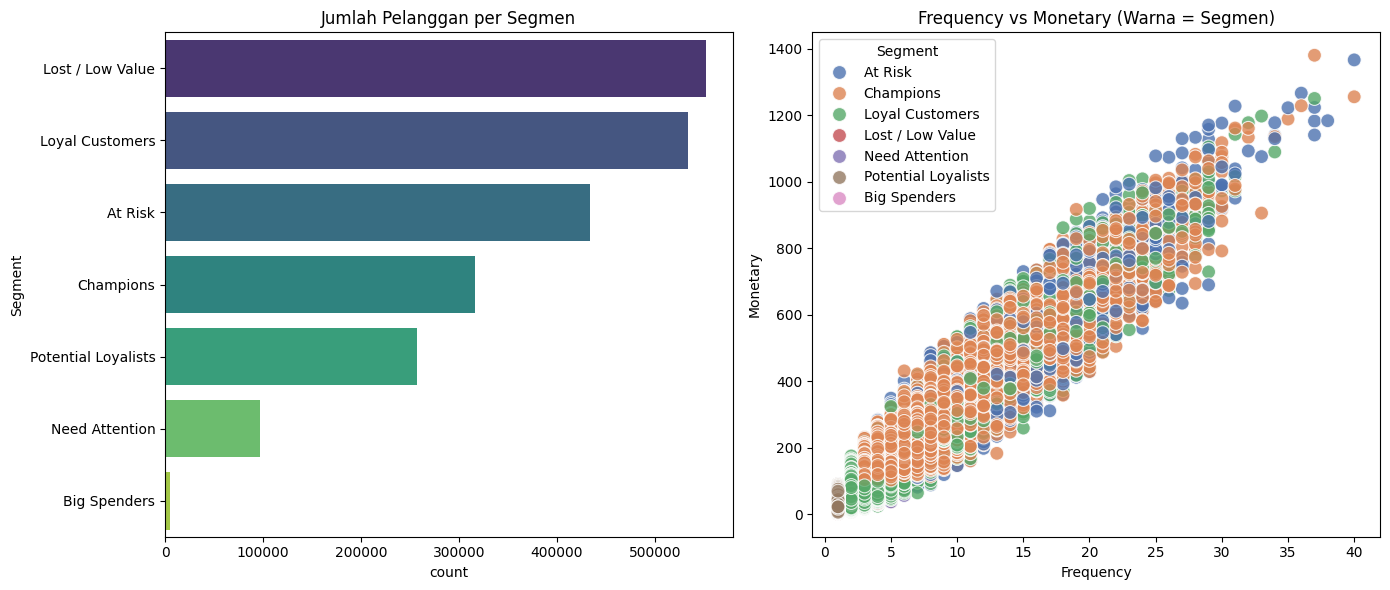

In [33]:
# 2. Visualisasi Sederhana di Python (Preview Power BI)
plt.figure(figsize=(14, 6))

# Bar Chart Jumlah Customer
plt.subplot(1, 2, 1)
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Jumlah Pelanggan per Segmen')

# Scatter Plot Frequency vs Monetary
plt.subplot(1, 2, 2)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='deep', s=100, alpha=0.8)
plt.title('Frequency vs Monetary (Warna = Segmen)')

plt.tight_layout()
plt.show()

In [ ]:
rfm.to_csv("RFM_Analysis_Result.csv", index=False)